In [1]:
PATH_ = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"

In [2]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model, metrics
from sklearn.model_selection import KFold, cross_val_score
import os 
from matplotlib import pyplot as plt
import pickle
import seaborn as sb
import pandas as pd
import numpy as np
from scipy import stats
import sys
sys.path.append('C:\\Users\\ICN_admin\\Documents\\icn\\icn_stats\\')
import icn_permutation_test

In [3]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

In [4]:
def evalerror(preds, dtrain):
        """
        Custom defined r^2 evaluation function
        """
        labels = dtrain.get_label()
        # return a pair metric_name, result. The metric name must not contain a
        # colon (:) or a space since preds are margin(before logistic
        # transformation, cutoff at 0)

        r2 = metrics.r2_score(labels, preds)

        if r2 < 0:
            r2 = 0

        return 'r2', r2

1. run the estimation of comb of all
2. store the prediction and label 
3. read them and calculate mean 
4. for every subject calculate spearman's rho with UPDRS and 
    1. prediction amplitude 
    2. delta label and prediction 


In [16]:
os.listdir(PATH_)

['sub_000_sess_right_run_0.p',
 'sub_000_sess_right_run_1.p',
 'sub_000_sess_right_run_2.p',
 'sub_000_sess_right_run_3.p',
 'sub_001_sess_left_run_0.p',
 'sub_001_sess_left_run_1.p',
 'sub_001_sess_left_run_3.p',
 'sub_001_sess_left_run_6.p',
 'sub_001_sess_left_run_7.p',
 'sub_001_sess_right_run_2.p',
 'sub_001_sess_right_run_4.p',
 'sub_001_sess_right_run_5.p',
 'sub_002_sess_right_run_0.p',
 'sub_002_sess_right_run_1.p',
 'sub_003_sess_left_run_1.p',
 'sub_003_sess_left_run_3.p',
 'sub_003_sess_right_run_0.p',
 'sub_003_sess_right_run_2.p',
 'sub_003_sess_right_run_4.p',
 'sub_003_sess_right_run_5.p',
 'sub_004_sess_left_run_0.p',
 'sub_004_sess_right_run_1.p',
 'sub_004_sess_right_run_2.p',
 'sub_005_sess_left_run_0.p',
 'sub_005_sess_left_run_1.p',
 'sub_005_sess_left_run_3.p',
 'sub_005_sess_left_run_4.p',
 'sub_005_sess_right_run_2.p',
 'sub_006_sess_left_run_0.p',
 'sub_006_sess_left_run_3.p',
 'sub_006_sess_left_run_5.p',
 'sub_006_sess_right_run_1.p',
 'sub_006_sess_right_ru

In [24]:
# COMBINATION ECOG, STN and both
df = pd.DataFrame()
time_stamps = 5

for f in range(len(os.listdir(PATH_))):
    sub_ = os.listdir(PATH_)[f][4:7]
    if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        continue
    print(sub_)
    with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
        run_ = pickle.load(handle)
        print(run_["ch_names"])
        if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
            continue
        print("PROCESS")
        X_ = []
        start = True
        for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
            #ECOG_STN combines all 
            X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], \
                                   run_["label_baseline_corrected"][0,:], \
                                   time_stamps=time_stamps)
            if start == True:
                X_ = X
                start = False
            else:
                X_ = np.concatenate((X_, X), axis=1)

        for label_idx, label in enumerate(run_["label_baseline_corrected"]):
            pred_ = []
            label_ = []
            cv = KFold(n_splits=3, shuffle=False)
            for train_index, test_index in cv.split(X):
                #res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X_, label=label[time_stamps:]), 
                #              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                Xtr, Xte=X_[train_index,:], X_[test_index,:]
                ytr, yte=label[time_stamps:][train_index], label[time_stamps:][test_index]
                model = xgb.XGBRegressor()
                pred_.append(model.fit(Xtr, ytr).predict(Xte))
                label_.append(yte)

            if run_["label_con_true"][label_idx] is True:
                lat = "CON"
            else:
                lat = "IPS"
            if "LEFT" in ch_:
                hem = "LEFT"
            else:
                hem = "RIGHT"
            df = df.append({
                "sub": sub_,
                "lat": lat, 
                "hem": hem, 
                "pred" : np.concatenate(pred_), 
                "label" : np.concatenate(label_)
            }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 

['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
006
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIG

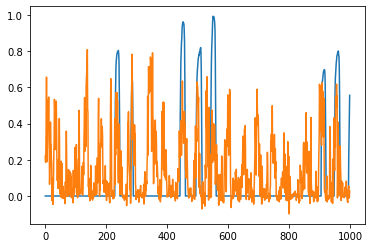

In [171]:
plt.plot(np.concatenate(label_)[:1000])
plt.plot(np.concatenate(pred_)[:1000])

In [90]:
def get_epochs(y_test, y_pred, epoch_lim=10, threshold=0.5):
    ind_mov = np.where(np.diff(np.array(y_test>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_test.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    y_pred_epoch = np.zeros([ind_mov.shape[0], 20])
    y_true_arr = np.zeros([ind_mov.shape[0], 20])

    for idx, i in enumerate(ind_mov):
        y_pred_epoch[idx,:] = y_pred[i-epoch_lim:i+epoch_lim]
        y_true_arr[idx,:] = y_test[i-epoch_lim:i+epoch_lim]

    return y_true_arr, y_pred_epoch

### concatenate every session and con and ips

In [176]:
dict_ = {}
for sub in df["sub"].unique():
    start = True
    for hem in ["RIGHT", "LEFT"]:
        for lat in ["CON", "IPS"]:
            df_extract = df[(df["sub"] == sub) &(df["lat"] == lat) & (df["hem"] == hem)]
            if df_extract.shape[0] == 0:
                continue
            if start == True:
                start = False
                y_pr = df_extract["pred"].iloc[0]
                y_true = df_extract["label"].iloc[0]
            else:
                y_pr = np.concatenate((y_pr, df_extract["pred"].iloc[0]), axis=0)
                y_true = np.concatenate((y_true, df_extract["label"].iloc[0]), axis=0)

    dict_[sub] = {
        "pred" : y_pr,
        "true" : y_true
    }

### read UPDRS scores and calculate epochs

In [177]:
y_epoch_true, y_epoch_pr = get_epochs(dict_["001"]["true"], dict_["001"]["pred"], threshold=0.5)

In [178]:
np.array(y_epoch_true).shape

(168, 20)

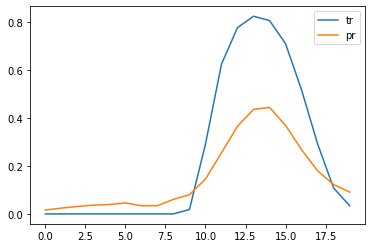

In [179]:
plt.plot(np.mean(np.array(y_epoch_true), axis=0), label="tr")
plt.plot(np.mean(np.array(y_epoch_pr), axis=0), label="pr")
plt.legend()

In [180]:
df_UPDRS = pd.read_csv("..\\df_all.csv", index_col=0)

In [191]:
df_comp = pd.DataFrame()
mean_arr_delta = np.zeros([20, 11])
mean_arr_pred = np.zeros([20, 11])
updrs = []
start = True

for sub_idx, sub in enumerate(['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']):
    updrs.append(list(df_UPDRS[(df_UPDRS["sub"] == int(sub))]["UPDRS_total"])[0])
    y_epoch_true, y_epoch_pr = get_epochs(dict_[sub]["true"], dict_[sub]["pred"], threshold=0.5)
    if start is True:
        y_TRUE = y_epoch_true; y_PRED = y_epoch_pr
        start = False
    else: 
        y_TRUE = np.concatenate((y_TRUE, y_epoch_true), axis=0)
        y_PRED = np.concatenate((y_PRED, y_epoch_pr), axis=0)
    mean_arr_pred[:, sub_idx] = np.mean(y_epoch_pr, axis=0)
    mean_arr_delta[:, sub_idx] = np.mean(y_epoch_true, axis=0) - np.mean(y_epoch_pr, axis=0)

In [182]:
y_epoch_pr.shape

(45, 20)

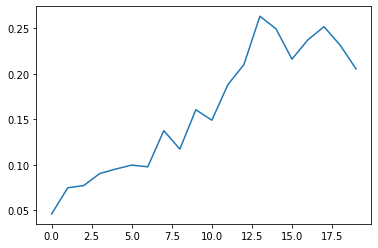

In [183]:
plt.plot(y_epoch_pr.mean(axis=0))

### calculate spearman's rho for every 10Hz iteration 

In [184]:
mean_arr_delta.shape

(20, 11)

In [185]:
sprho_arr_delta = np.zeros([20])
sprho_arr_pred = np.zeros([20])
for i in range(20):
    sprho_arr_delta[i] = stats.spearmanr(mean_arr_delta[i,:], updrs)[0]
    sprho_arr_pred[i] = stats.spearmanr(mean_arr_pred[i,:], updrs)[0]

In [192]:
y_TRUE.shape

(869, 20)

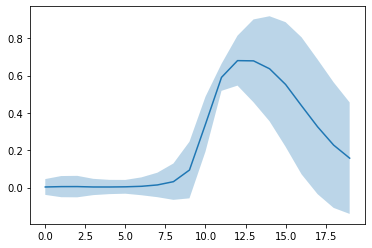

In [195]:
plt.plot(y_TRUE.mean(axis=0))
plt.fill_between(np.arange(0,20,1),y_TRUE.mean(axis=0)-y_TRUE.std(axis=0), y_TRUE.mean(axis=0)+y_TRUE.std(axis=0), 
                alpha=0.3)

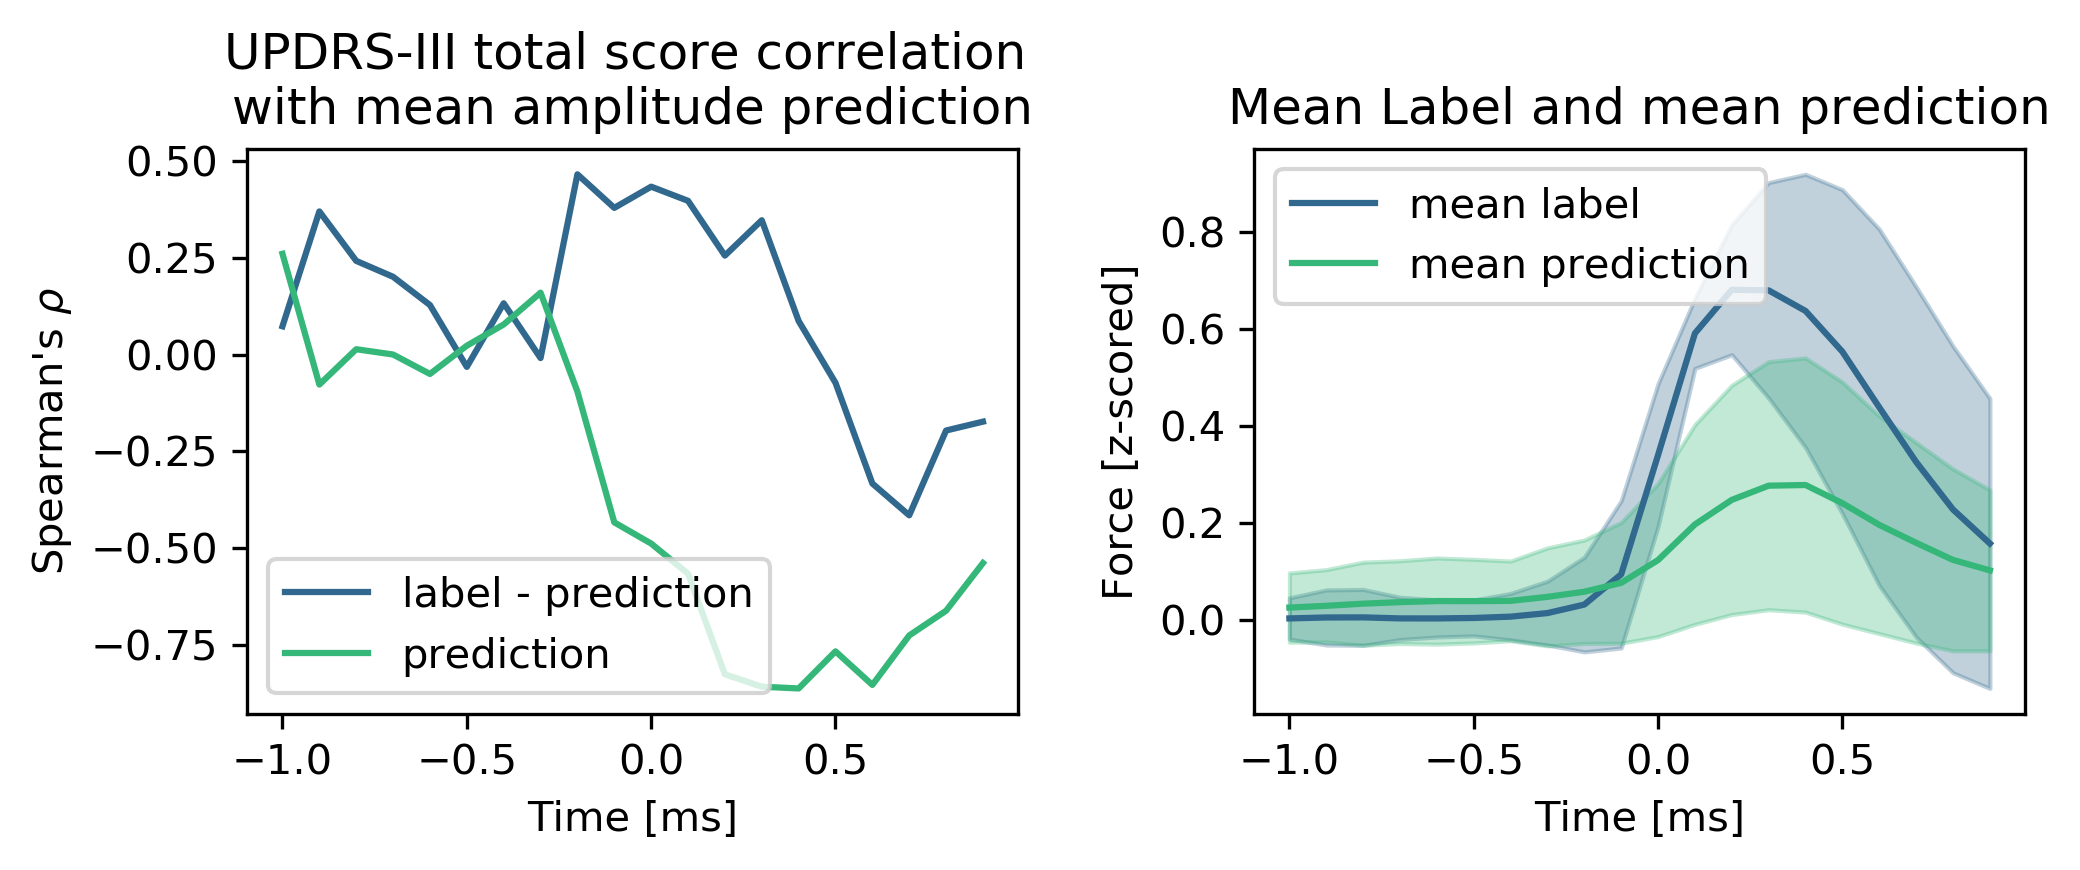

In [199]:
plt.figure(figsize=(7,3), dpi=300)
plt.subplot(121)
x_ = np.arange(-10, 10, 1)*0.1
plt.plot(x_, sprho_arr_delta, label="label - prediction", color=(49/255,104/255,142/255))
plt.plot(x_, sprho_arr_pred, label = "prediction",color=(53/255,183/255,121/255))
plt.ylabel("Spearman's "+r"$\rho$")
plt.xlabel("Time [ms]")
plt.legend()
plt.title("UPDRS-III total score correlation \nwith mean amplitude prediction")

plt.subplot(122)
plt.xlabel("Time [ms]")
plt.ylabel("Force [z-scored]")
plt.plot(x_, y_TRUE.mean(axis=0), label="mean label", color=(49/255,104/255,142/255))
plt.plot(x_, y_PRED.mean(axis=0), label="mean prediction", color=(53/255,183/255,121/255))
plt.fill_between(x_,y_TRUE.mean(axis=0)-y_TRUE.std(axis=0), y_TRUE.mean(axis=0)+y_TRUE.std(axis=0), 
                alpha=0.3, color=(49/255,104/255,142/255))
plt.fill_between(x_,y_PRED.mean(axis=0)-y_PRED.std(axis=0), y_PRED.mean(axis=0)+y_PRED.std(axis=0), 
                alpha=0.3, color=(53/255,183/255,121/255))


plt.title("Mean Label and mean prediction")
plt.legend()
plt.tight_layout()